In [3]:
# import library
import re
import os 
import glob
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, Nadam
from keras.applications import vgg19
from keras import callbacks
from keras import optimizers, losses


In [4]:
# define base path
base_path = '../dataset_final/train'
test_path = '../dataset_final/test'
# check data classes
classes = os.listdir(base_path)
print(classes)

# count data
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(len(img_list))

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']
6584


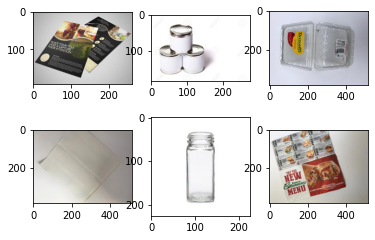

In [5]:
# plot some random image at random classes
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [15]:
# use ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range = 20,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(base_path,
                                                   target_size=(224,224),
                                                   batch_size=100,
                                                   class_mode='categorical',
                                                   subset='training',
                                                   shuffle=True,
                                                   seed=0)

validation_generator = train_datagen.flow_from_directory(base_path,
                                                        target_size=(224,224),
                                                        batch_size=100,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True,
                                                        seed=0)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=100,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=0)

labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
print(labels)

Found 5269 images belonging to 6 classes.
Found 1315 images belonging to 6 classes.
Found 70 images belonging to 1 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [21]:
# Use VGG19 transfer learning to set our model
base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

# Define trainable model which links input from the  base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the vgg19 base model
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print (model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [11]:
# set early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [22]:
# fit model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks = [early_stop],
                    verbose=1)


Epoch 1/20
11/53 [=====>........................] - ETA: 14:04 - loss: 3.8446 - accuracy: 0.2073

KeyboardInterrupt: 

In [14]:
# save best model
model.save('VGG19_model3.h5')
print('model saved')

model saved


In [17]:
# evaluate the model
score = model.evaluate_generator(validation_generator, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

14/14 [==============================] - 212s 15s/step - loss: 0.9157 - accuracy: 0.6897
Test loss:  0.9157456755638123
Test accuracy:  0.6897338628768921


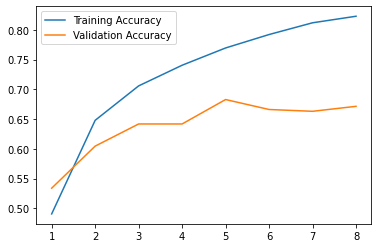

In [18]:
# plot data to see relationships in training and validation data
epoch_list = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epoch_list, history.history['accuracy'], epoch_list, history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

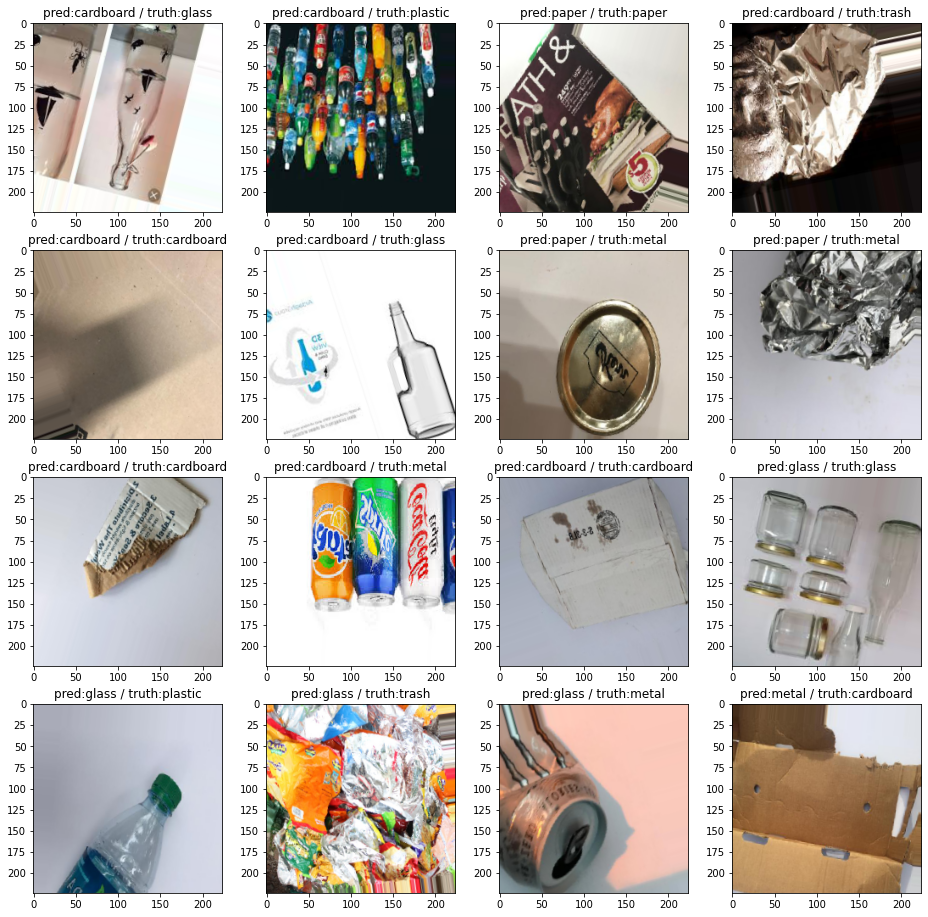

In [20]:
# make prediction
preds = model.predict(test_generator)

plt.figure(figsize=(16, 16))
# use 16 image to predict
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(y_test[i])]))
    plt.imshow(X_test[i])